<b>Connecting to the Twitter API</b>

In [263]:
import tweepy
auth = tweepy.OAuthHandler("6R6MJUxLEpLIrkSJGiBguKMRv", 
    "eyIukOMw4h9zkUJfMlcrDtJcdUXT9l9WOtgIc0c5dDOf9twdBY")
auth.set_access_token("1033566666305589248-r3tbQuBFTyv6NoMomhfYprOkSypSYD", 
    "ewvQW8I3zBMlHwTpg1iDArytjcJ24RwdXRuGJwbJ69cIH")

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication is verified")
except:
    print("Authentication Failed")

Authentication is verified


<b>Extracting the Tweets</b>

In [115]:
import tweepy
import csv

hashtags = ['#southerncalifornia']

#I have used the following tags for craetion of my dataset.
#["#USC", '#fighton', '#uscfootball', '#trojan', '#uscgrad', '#usctrojans', '#universityofsoutherncalifornia', '#uscalumni']

unique_tweets = set()

for hashtag in hashtags:
    for tweet in tweepy.Cursor(api.search_tweets, q=hashtag, lang="en", tweet_mode="extended").items(400):
        if tweet not in unique_tweets:
            unique_tweets.add(tweet)

with open(f"usc_tweets.csv", "a", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Username", "Date", "Time", "Tweet"])
    for tweet in unique_tweets:
        writer.writerow([tweet.user.screen_name, tweet.created_at.date(), tweet.created_at.time(), tweet.full_text])


<b>Preprocessing the Text<b>

In [243]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

def preprocess_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@\S+', '', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    return tweet

def tokenize_tweet(tweet):
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens if word not in stop_words]
    return tokens

tweet_data = pd.read_csv('usc_tweets.csv')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

tweet_data['Tweet'] = tweet_data['Tweet'].apply(preprocess_tweet)
tweet_data['tokens'] = tweet_data['Tweet'].apply(tokenize_tweet)

tweet_data.to_csv('tweets_dataset_preprocessed.csv', index=False)


<b>Feature Extraction:</b>

In [244]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load the preprocessed data from the CSV file
tweet_data = pd.read_csv("tweets_dataset_preprocessed.csv")

# Extract bag-of-words features
vectorizer = CountVectorizer()
bow_features = vectorizer.fit_transform(tweet_data['Tweet'])

# Extract TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(tweet_data['Tweet'])

# Print the shape of the feature matrices
print(f"Bag-of-words features shape: {bow_features.shape}")
print(f"TF-IDF features shape: {tfidf_features.shape}")


Bag-of-words features shape: (2371, 6735)
TF-IDF features shape: (2371, 6735)


<b>Sentiment Analysis</b>

In [245]:
import pandas as pd
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

tweet_data = pd.read_csv("tweets_dataset_preprocessed.csv")

tweets = tweet_data["Tweet"].tolist()

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

sentiments = nlp(tweets)

tweet_data["sentiment"] = [sentiment["label"] for sentiment in sentiments]
tweet_data.to_csv("tweets_dataset_preprocessed.csv", index=False)


<b>Model Implementation</b>

In [247]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


tweet_data = pd.read_csv("tweets_dataset_preprocessed.csv")

label_encoder = LabelEncoder()

tweet_data['sentiment'] = label_encoder.fit_transform(tweet_data['sentiment'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_data['Tweet'])
sequences = tokenizer.texts_to_sequences(tweet_data['Tweet'])

max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, tweet_data['sentiment'], test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(256, return_sequences=True))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=64)

Epoch 1/25
30/30 [==============================] - 34s 865ms/step - loss: 0.6663 - accuracy: 0.6150 - val_loss: 0.6201 - val_accuracy: 0.6943
Epoch 2/25
30/30 [==============================] - 25s 836ms/step - loss: 0.5980 - accuracy: 0.6943 - val_loss: 0.5728 - val_accuracy: 0.7177
Epoch 3/25
30/30 [==============================] - 25s 829ms/step - loss: 0.5231 - accuracy: 0.7240 - val_loss: 0.5928 - val_accuracy: 0.7192
Epoch 4/25
30/30 [==============================] - 24s 811ms/step - loss: 0.4789 - accuracy: 0.7479 - val_loss: 0.6505 - val_accuracy: 0.7232
Epoch 5/25
30/30 [==============================] - 24s 813ms/step - loss: 0.4570 - accuracy: 0.7563 - val_loss: 0.6751 - val_accuracy: 0.7196
Epoch 6/25
30/30 [==============================] - 24s 816ms/step - loss: 0.4430 - accuracy: 0.7613 - val_loss: 0.7660 - val_accuracy: 0.7259
Epoch 7/25
30/30 [==============================] - 25s 827ms/step - loss: 0.4376 - accuracy: 0.7635 - val_loss: 0.7761 - val_accuracy: 0.7237

<b>Sentiment Analysis on New Sentences</b>

In [254]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [
    "I love this movie",
    "The food at the restaurant was horrible and gave me bad food poisoning.",
    "The food at the restaurant was amazing",
    "I can't believe how bad the service was",
    "This book is so amazing",
    "The concert was incredible",
    "I'm feeling really exhausted",
    "The traffic jam ruined my day",
    "The party was excellent yesterday",
    "I had a terrible experience at the theme park",
    "The weather today is irritating to spend time outside.",
    "The sky is blue and the grass is green."
]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

sequences = tokenizer.texts_to_sequences(sentences)
max_length = max(len(seq) for seq in sequences)

padded_sequences = pad_sequences(sequences, maxlen=55, padding='post')

predictions = model.predict(padded_sequences)

sentiment_labels = ["Negative", "Positive"]
predicted_sentiments = [sentiment_labels[np.argmax(pred)] if np.argmax(pred) < len(sentiment_labels) else "Neutral" for pred in predictions]

for sentence, sentiment in zip(sentences, predicted_sentiments):
    print("Sentence: ", sentence)
    print("Predicted Sentiment: ", sentiment)
    print()


1/1 [==============================] - 0s 79ms/step
Sentence:  I love this movie
Predicted Sentiment:  Positive

Sentence:  The food at the restaurant was horrible and gave me bad food poisoning.
Predicted Sentiment:  Neutral

Sentence:  The food at the restaurant was amazing
Predicted Sentiment:  Positive

Sentence:  I can't believe how bad the service was
Predicted Sentiment:  Neutral

Sentence:  This book is so amazing
Predicted Sentiment:  Negative

Sentence:  The concert was incredible
Predicted Sentiment:  Negative

Sentence:  I'm feeling really exhausted
Predicted Sentiment:  Neutral

Sentence:  The traffic jam ruined my day
Predicted Sentiment:  Negative

Sentence:  The party was excellent yesterday
Predicted Sentiment:  Positive

Sentence:  I had a terrible experience at the theme park
Predicted Sentiment:  Neutral

Sentence:  The weather today is irritating to spend time outside.
Predicted Sentiment:  Negative

Sentence:  The sky is blue and the grass is green.
Predicted Sent

<b>Results and evaluation metrics</b>

In [32]:
print("Classification report: ")
print(classification_report(y_test, y_pred))


Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       183
           1       0.80      0.85      0.82       178

    accuracy                           0.82       361
   macro avg       0.82      0.82      0.82       361
weighted avg       0.82      0.82      0.82       361



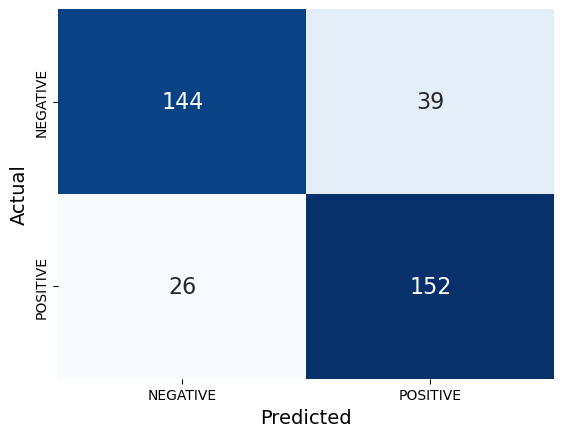

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 16}, 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()


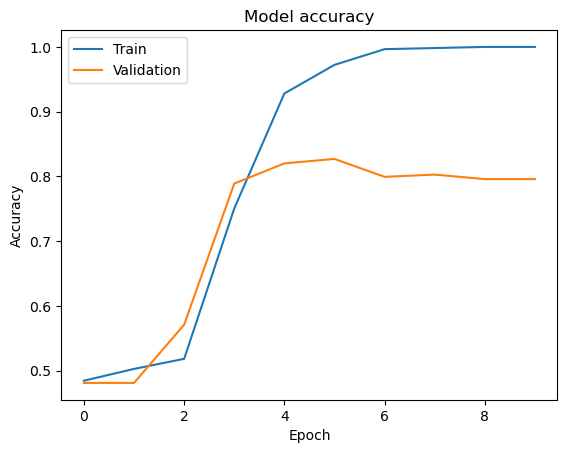

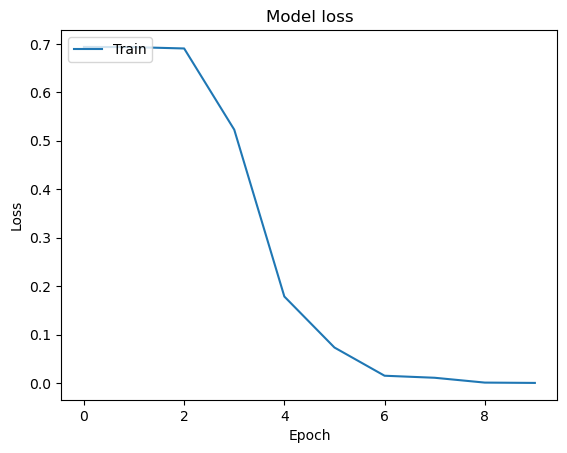

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()
